# Brief comparison between `OneHotEncoder` and `StringDistanceEncoder` for prediction

## 1) Loading and preparing data

First, we will load the data and take a look at the values of the resulting DataFrame.

In [1]:
import pandas as pd

data = pd.read_csv("Salary_Data.csv")
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


Note that there are three numeric variables (`Age`, `Years of Experience`, and `Salary`) and three categorical variables (`Gender`, `Education Level`, `Job Title`). The latter are of most interest to us for this example.

Before we continue, let's see how many rows there are in this dataset:

In [2]:
len(data)

6704

There are 6704 rows, where one or another, of course, must have some missing value. But before we analyze that, let's focus on getting the count of unique values for the categorical variables:

In [3]:
with pd.option_context('display.max_rows', None,):
    for col in data.columns:
        if col in ["Age", "Years of Experience", "Salary"]:
            continue
        else:
            print("\n" + "*"*50)
            print(f"{col.upper()}")
            print(f"TOTAL: {len(data[col].unique())}")
            print(data[col].value_counts())


**************************************************
GENDER
TOTAL: 4
Gender
Male      3674
Female    3014
Other       14
Name: count, dtype: int64

**************************************************
EDUCATION LEVEL
TOTAL: 8
Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

**************************************************
JOB TITLE
TOTAL: 194
Job Title
Software Engineer                        518
Data Scientist                           453
Software Engineer Manager                376
Data Analyst                             363
Senior Project Engineer                  318
Product Manager                          313
Full Stack Engineer                      309
Marketing Manager                        255
Back end Developer                       244
Senior Software Engineer                 244
Front end Developer 

Note that there are some small differences in the typing between the categories of the `Education Level` variable, but they are not impactful for the machine learning models in terms of cardinality. However, for the `Job Title` variable, note that there are 194 unique values, among which there is a significant number containing only one instance. In this case, reducing cardinality through the use of `StringDistanceEncoder` can be of great value.

Let's now analyze the percentage of missing values in each column of the DataFrame:

In [4]:
data.isna().sum()/len(data)*100

Age                    0.029833
Gender                 0.029833
Education Level        0.044749
Job Title              0.029833
Years of Experience    0.044749
Salary                 0.074582
dtype: float64

Since the percentage of missing values is low for the columns, for the purposes of this example we can be content with just deleting the rows containing missing values:

In [5]:
data.dropna(how="any", inplace=True)

print(data.isna().sum()/len(data)*100)
print("New total of rows:", len(data))

Age                    0.0
Gender                 0.0
Education Level        0.0
Job Title              0.0
Years of Experience    0.0
Salary                 0.0
dtype: float64
New total of rows: 6698


Note that the new total number of rows is 6698, which is almost no difference compared to the initial number.

Let's now prepare the data for modeling, using the `Salary` column as the dependent variable and the rest of the columns as dependent variables:

In [6]:
X = data.drop(columns=["Salary"])
y = data["Salary"].values

## 2) Modeling using `OneHotEncoder`

When modeling using `OneHotEncoder`, we can expect that the `Ridge` regression model will have to make use of all 194 categories present in the data for the `Job Title` column. In more complex datasets, this can be quite detrimental in terms of overfitting if the categories are not properly processed/normalized.

Below is all the code related to the modeling:

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

col_transforms = ColumnTransformer([("OHE_gender", OneHotEncoder(handle_unknown="ignore"), ["Gender"]),
                                    ("OHE_education", OneHotEncoder(handle_unknown="ignore"), ["Education Level"]),
                                    ("OHE_job_title", OneHotEncoder(handle_unknown="ignore"), ["Job Title"])],
                                   remainder="passthrough")

naive_pipe = Pipeline([("col_transforms", col_transforms),
                       ("regressor", Ridge(random_state=668))])

kfold = KFold(n_splits=10, shuffle=True, random_state=669)

naive_results = -cross_val_score(naive_pipe, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

The relevant results in terms of RMSE for the 10 folds generated are shown below:

In [8]:
print("Results per fold:")
print(naive_results)
print("Mean RMSE:", naive_results.mean())
print("Std RMSE:", naive_results.std())

Results per fold:
[17752.018424   19208.2363638  18941.2741853  17223.56487485
 18990.09916807 18404.48847088 19043.29129139 19375.15249527
 17931.03042445 17929.86923761]
Mean RMSE: 18479.902493561356
Std RMSE: 695.715318996579


## 3) Modeling using `StringDistanceEncoder`

When modeling using `StringDistanceEncoder`, we can choose the number of components to represent the distances between the corresponding strings of each category. This is extremely useful for linear models, as we can aim to keep the cardinality at its minimum, increasing the chances of the model generalizing to data outside the training set. In this example, 2 components will be used for the `Education Level` variable and 5 components for the `Job Title` variable.

Below is all the code related to the modeling:

In [9]:
from StringDistanceEncoder import StringDistanceEncoder

education_distance_encoding_pipe = Pipeline([("distance_encoding", StringDistanceEncoder(n_components=2)),
                                            ("OHE", OneHotEncoder(handle_unknown="ignore"))])

job_title_distance_encoding_pipe = Pipeline([("distance_encoding", StringDistanceEncoder(n_components=5)),
                                            ("OHE", OneHotEncoder(handle_unknown="ignore"))])

col_transforms_distance_encoding = ColumnTransformer([("OHE_gender", OneHotEncoder(handle_unknown="ignore"), ["Gender"]),
                                    ("OHE_education", education_distance_encoding_pipe, ["Education Level"]),
                                    ("OHE_job_title", job_title_distance_encoding_pipe, ["Job Title"])],
                                   remainder="passthrough")

distance_encoding_pipe = Pipeline([("col_transforms", col_transforms_distance_encoding),
                                   ("regressor", Ridge(random_state=668))])

distance_encoding_results = -cross_val_score(distance_encoding_pipe, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

The relevant results in terms of RMSE for the 10 folds generated are shown below:

In [10]:
print("Results per fold:")
print(distance_encoding_results)
print("Mean RMSE:", distance_encoding_results.mean())
print("Std RMSE:", distance_encoding_results.std())

Results per fold:
[17703.74767275 19112.21214879 18799.4427444  17152.64667413
 18914.74648229 18314.55720995 18808.59030876 19179.41012845
 17911.72447601 17727.22571508]
Mean RMSE: 18362.430356061857
Std RMSE: 665.6630016882208


## 4) Comparing the results

To compare the results more intuitively, we can plot the RMSE obtained for each fold:

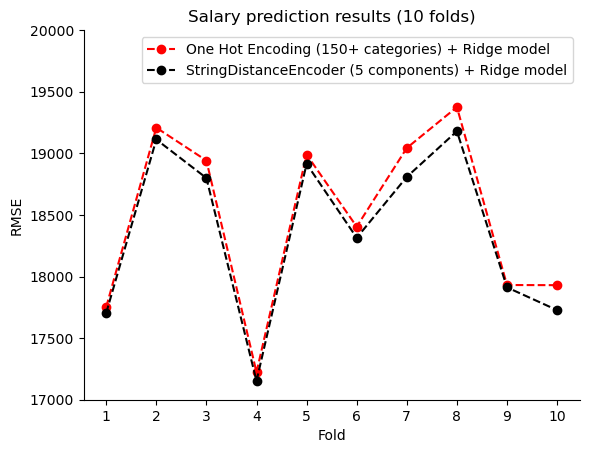

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), naive_results, label="One Hot Encoding (150+ categories) + Ridge model",
        linestyle="--", marker="o", color="red")
plt.plot(range(1, 11), distance_encoding_results, label="StringDistanceEncoder (5 components) + Ridge model",
        linestyle="--", marker="o", color="black")
plt.title("Salary prediction results (10 folds)")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.ylim((17000, 20000))
plt.gca().set_xticks(range(1, 11))
plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend()
plt.savefig("salary_prediction_results.png", dpi=400)
plt.show()

As we can see in the plot above, the use of `StringDistanceEncoder` was extremely advantageous. In addition to making it possible to use a smaller number of features for prediction compared to `OneHotEncoder`, there was a decrease in RMSE for all folds, which indicates an improvement in performance.